In [96]:
using Distributions, Plots
include("../src/babyNewsvendor.jl")

JS

In [111]:
pyplot()
srand(8675309)

#Gen Pks uniformly over interval for now
K = 10001
ps = rand(K);
N = 20
Nhats = rand(Poisson(N), K);

### Baseline Oracle Curve for intuitive playing.

In [113]:
mhats = JS.sim_path(ps, Nhats);

s = .9 #Service level  #b = s/(1-s)
p0 = .5
alpha_grid = linspace(0, N, 100)

zstar = JS.exp_nv_fullInfo(ps, s)
alphaOR, jstar, outOR = JS.oracle_alpha(mhats, ps, p0, alpha_grid, Nhats, s)
alphaApriori, jstar, outAP = JS.apriori_alpha(ps, p0, alpha_grid, Nhats, s)
alphaLOO, jstar, outLOO = JS.loo_alpha(mhats, p0, alpha_grid, Nhats, s)
alphaOR, alphaLOO

(2.0202020202020203, 1.6161616161616161)

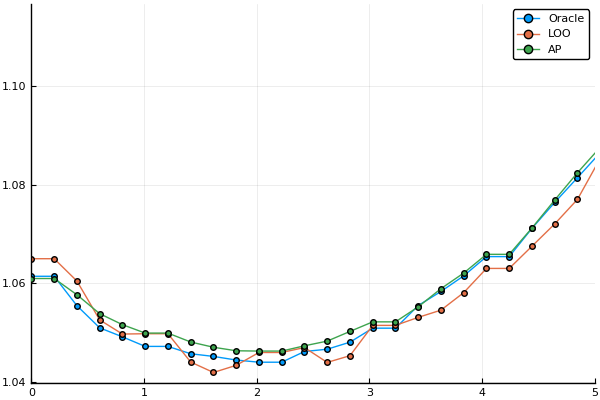

In [114]:
plot(alpha_grid, [outOR/zstar outLOO/N/zstar outAP/zstar] , marker=:circ, label=["Oracle" "LOO" "AP"])
#ylabel!("% Benefit over SAA")
xlims!(0, 5)

In [72]:
[outLOO/N outAP outOR]/zstar

100×3 Array{Float64,2}:
 0.997114  1.08104  1.08157
 0.980688  1.06784  1.06813
 0.968421  1.05963  1.05959
 0.960265  1.05532  1.05515
 0.956072  1.05318  1.05297
 0.954994  1.05173  1.05149
 0.954745  1.05079  1.05063
 0.958819  1.04855  1.04857
 0.967996  1.04588  1.04592
 0.981993  1.04368  1.04387
 0.99939   1.04316  1.04328
 1.00813   1.04375  1.04369
 1.02412   1.04556  1.04559
 ⋮                         
 1.0525    1.0527   1.0527 
 1.0525    1.0527   1.0527 
 1.0525    1.0527   1.0527 
 1.0525    1.0527   1.0527 
 1.0525    1.0527   1.0527 
 1.0525    1.0527   1.0527 
 1.0525    1.0527   1.0527 
 1.0525    1.0527   1.0527 
 1.0525    1.0527   1.0527 
 1.0525    1.0527   1.0527 
 1.0525    1.0527   1.0527 
 1.0525    1.0527   1.0527 

### An example for paper where tweaking the costs in a small way dramatically changes value of shrinkage

In [ ]:
N = 20
p0 = .5 #mean(ps)
K = length(ps)
s1 = .955
s2 = .95

out = map(a-> JS.exp_nv_obj(ps, p0, a, N, s1), alpha_grid) 
benefit = 1 - out/out[1]
println("Oracle Benefit:\t", maximum(benefit))
println("Max Possible:\t", 1- JS.exp_nv_fullInfo(ps, s1)/out[1])


out = map(a-> JS.exp_nv_obj(ps, p0, a, N, s2), alpha_grid) 
benefit2 = 1 - out/out[1]

println()
println("Oracle Benefit:\t", maximum(benefit2))
println("Max Possible:\t", 1- JS.exp_nv_fullInfo(ps, s2)/out[1])

plot(alpha_grid, 100 *[benefit benefit2], marker=:circ)
xlims!(0, 10)

### How does changing service level change size of benefit?

In [ ]:
N = 20
#println("Mean ps = p0: \t", mean(ps))
p0 = .5

function oracle_benefit(p0, N, s)
    out = map(a-> JS.exp_nv_obj(ps, p0, a, N, s), alpha_grid)     
    #maximum(1 - out/out[1])
    maximum(1 - out)
end

#full_info_benefit(p0, N, s) = 1- JS.exp_nv_fullInfo(ps, s) / JS.exp_nv_obj(ps, p0, 0, N, s)
full_info_benefit(p0, N, s) = 1- JS.exp_nv_fullInfo(ps, s) 

s_grid = linspace(.2, .99, 100)
or_out = oracle_benefit.(p0, N, s_grid)
saa_out = 1- map(s-> JS.exp_nv_obj(ps, p0, 0, N, s), s_grid)
full_out = full_info_benefit.(p0, N, s_grid);


In [ ]:
plot(s_grid, 100 * [or_out, saa_out, full_out], marker=:circ, labels=["Oracle" "Saa" "Full-Info"])
ylabel!("% Benefit over SAA")
xlims!(.6, 1)

### Convergence for a fixed Alpha?

In [105]:
K = 2^25
ps = rand(K);
N = 20
s = .5 #Service level  #b = s/(1-s)
p0 = .5
alpha = 1  #bayes optimal value 

srand(86309)
Nhats = rand(Poisson(N), K);
mhats = JS.sim_path(ps, Nhats);

K_grid = 2.^(8:25)
out1 = zeros(length(K_grid))
out2 = zeros(length(K_grid))

for i = 1:length(K_grid)
    out1[i] = JS.nv_obj(mhats[1:K_grid[i]], ps[1:K_grid[i]], p0, alpha, Nhats[1:K_grid[i]], s) 
    out2[i] = JS.nv_loo(mhats[1:K_grid[i]], p0, alpha, Nhats[1:K_grid[i]], s)/N
end



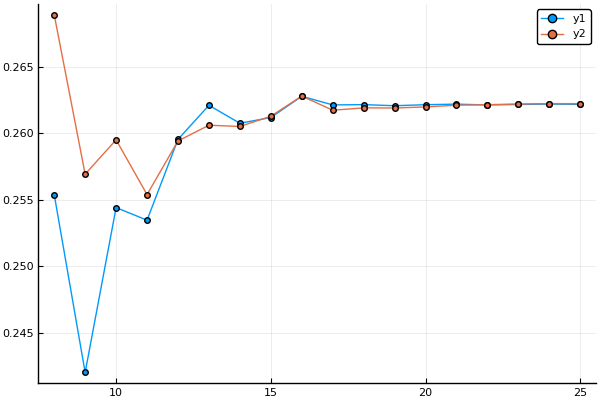

In [106]:
plot(log2.(K_grid), [out1 out2], marker=:circ)

### Some Notes
 - Oracle can offer no benefit for all of p0 = 0, .5, 1
 - Normal approximation can be quite bad... suggests there is a benefit when there isn't.

### Original and shrunken cost-curves

In [ ]:
#Plots the SAA cost curve across p_k and the shrunken cost curve across p_k.  Notice, Benefits when p_k > 1-q.

saa_objs = map(p-> obj_k(0, p, p0), ps)
or_objs = map(p->obj_k(alphaOR, p, p0), ps)
#full_objs = map(p->obj_k(.99, p, p0), ps)

plot(ps, saa_objs, ".")
plot(ps, or_objs, ".r")
#plot(ps, full_objs, "--k")
axhline(out[1])
axhline(minimum(out), color="r")
axvline(1-q, linestyle="dotted", color="k")

In [ ]:
##Evaluate the "deriv" at two points equally spaced from 1-q

delta = .01
low = 1-q - delta
high= 1-q + delta

function prob_deriv(p, p0, alpha)
    prob_portion(alpha, p, p0) - prob_portion(0, p, p0)
end
delta_grid = linspace(0, 1-q, 30)
low = map(d->prob_deriv(1-q-d, p0, alphaOR), delta_grid)
high= map(d->prob_deriv(1-q+d, p0, alphaOR), delta_grid)

plot(delta_grid, low, "--k")
plot(delta_grid, high, "--r")



### Plots the losses for $p_k < 1-q$ vs. the benefits for $p_k > 1-q$

In [ ]:
floor.(Int, rand(K))
#floor.(rand(K), Int)
#? floor